<a href="https://colab.research.google.com/github/thedenaas/jub_ml/blob/main/fall_2022/lecture_4/assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from enum import Enum

from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_circles, load_iris
from sklearn.metrics import pairwise_distances
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from collections import defaultdict
import sys

In [18]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

Generate data fot the tasks

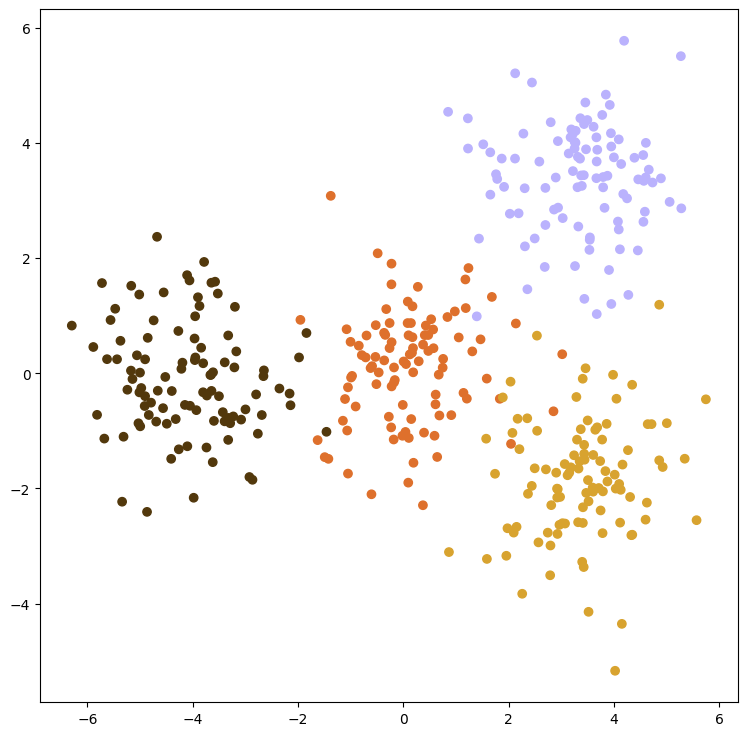

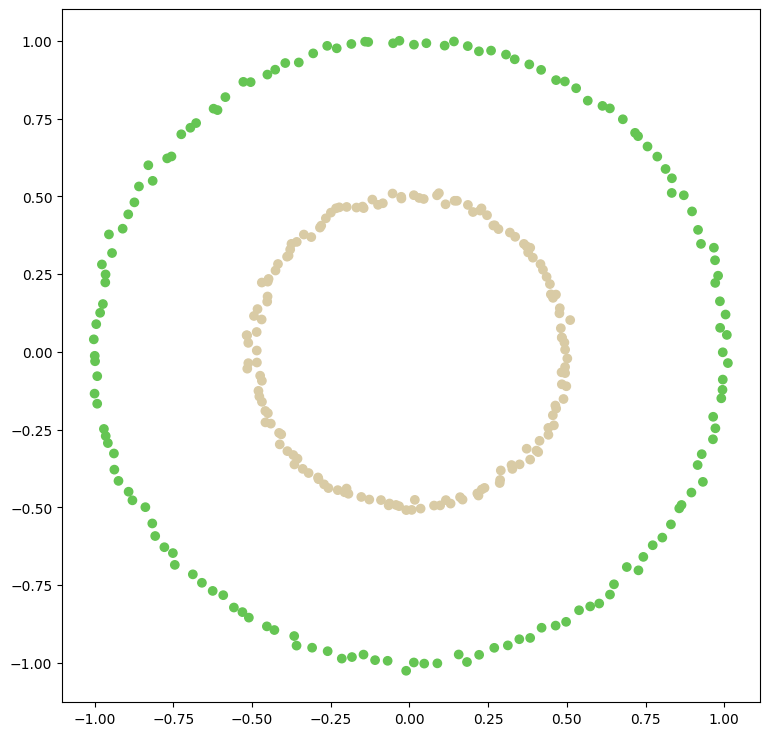

In [19]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_circles(n_samples=300, noise=0.01, factor=0.5)
visualize_clasters(X_2, true_labels)

X_iris = load_iris().data

### **Task 1. k-Means [20 pts]**
Implement k-means

#### initialization
* n_clusters - number of clusters
* init - how centers of the clusters are selected
    1. `random` - clusters' centroids are chosen at random
    2. `sample` - clusters' centroids are chosen at random from the given data

#### functionality
* `fit(X, y=None)` - initialize `self.centroids`, perform search for the best `self.centroids` values of clusters on the given data X (y is ignored)
* `predict(X)` - for each point in `X` returns number of the predicted cluster



__Don't forget to re-initialize empty cluster during the training for better convergence!__

In [20]:
class CentroidsChoosingMethod(Enum):
    Random = 0
    Sample = 1


def get_nearest_centroid_index(centroids, x):
    result_index = 0
    for i in range(len(centroids)):
        centroid = centroids[i]
        if np.linalg.norm(x - centroid) < np.linalg.norm(x - centroids[result_index]):
            result_index = i
    return result_index


def choose_new_centroid(method, X):
        if method == CentroidsChoosingMethod.Random:
            return np.random.random_sample((X.shape[1]))
        else:
            return X[np.random.randint(0, X.shape[0]), :]


class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        self.k = n_clusters
        self.max_iter = max_iter
        self.centroids_choosing = CentroidsChoosingMethod.Random if (
                    init == "random") else CentroidsChoosingMethod.Sample
        self.centroids = []
        self.eps = 0.001

    def fit(self, X, y=None):
        self.centroids = [choose_new_centroid(self.centroids_choosing, X) for _ in range(self.k)]

        for _ in range(self.max_iter):
            h = self.predict(X)

            some_centroid_changed = False
            for i in range(self.k):
                cluster_points = []
                for (point, centroid_index) in zip(X, h):
                    if centroid_index == i:
                        cluster_points.append(point)
                if len(cluster_points) == 0:
                    new_centroid = choose_new_centroid(self.centroids_choosing, X)
                else:
                    new_centroid = sum(cluster_points) / len(cluster_points)
                if np.linalg.norm(self.centroids[i] - new_centroid) > self.eps:
                    some_centroid_changed = True
                self.centroids[i] = sum(cluster_points) / len(cluster_points)
            if not some_centroid_changed:
                break

    def predict(self, X):
        return [get_nearest_centroid_index(self.centroids, x) for x in X]

Test on the synthetic data.

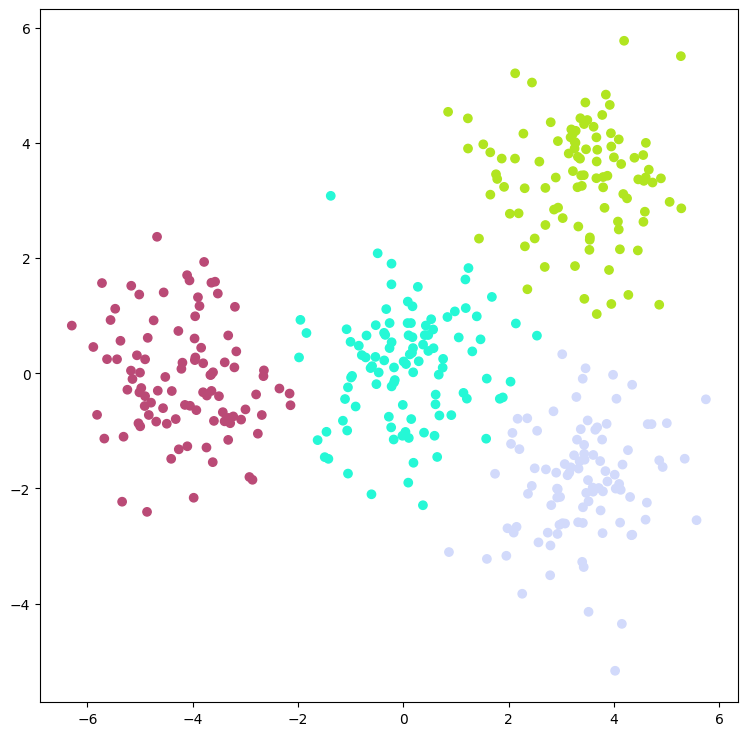

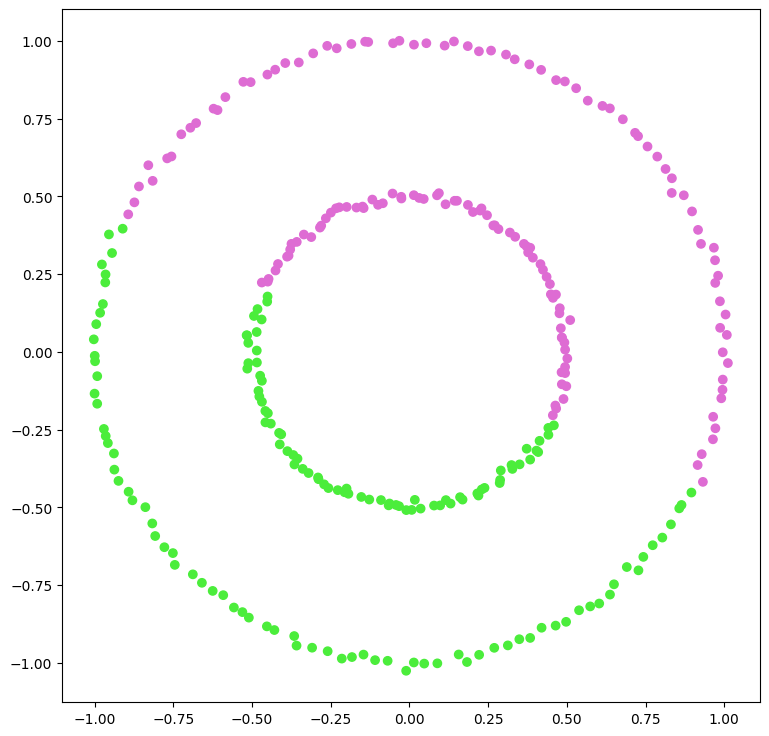

In [21]:
kmeans = KMeans(n_clusters=4, init="k-means++")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init="k-means++")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### **Task 2. k-Means++ [15 pts]**
Implement k-means++.


The only difference from k-Means is how clusters are initialized. Here centroids are chosen from the given data one by one. Each new centroid is chosen with the probability proportional to the squared distance to the closest exsitent centroid.


#### initialization
* n_clusters - number of clusters.

    
#### functionality
* `fit(X, y=None)` - initialize `self.centroids`, perform search for the best `self.centroids` values of clusters on the given data X (y is ignored)
* `predict(X)` - for each point in `X` returns number of the predicted cluster



__Don't forget to re-initialize empty cluster during the training for better convergence!__

In [22]:
class KMeans_pp:
    def __init__(self, n_clusters, max_iter=300):
        self.k = n_clusters
        self.max_iter = max_iter
        self.centroids = []
        self.eps = 0.001

    def fit(self, X, y=None):
        self.centroids = [X[np.random.randint(0, len(X))]]

        max_distance_from_centroids = [np.linalg.norm(self.centroids[0] - x) for x in X]

        for _ in range(self.k - 1):
            normalization_coef = np.linalg.norm(max_distance_from_centroids, ord=1)
            new_centroid = X[
                np.random.choice(range(len(X)), p=[dist / normalization_coef for dist in max_distance_from_centroids])]

            for i in range(len(max_distance_from_centroids)):
                max_distance_from_centroids[i] = min(max_distance_from_centroids[i],
                                                     np.linalg.norm(X[i] - new_centroid))

            self.centroids.append(new_centroid)

        for _ in range(self.max_iter):
            h = self.predict(X)

            some_centroid_changed = False
            for i in range(self.k):
                cluster_points = []
                for (point, centroid_index) in zip(X, h):
                    if centroid_index == i:
                        cluster_points.append(point)
                if len(cluster_points) == 0:
                    new_centroid = choose_new_centroid(CentroidsChoosingMethod.Sample, X)
                else:
                    new_centroid = sum(cluster_points) / len(cluster_points)
                if np.linalg.norm(self.centroids[i] - new_centroid) > self.eps:
                    some_centroid_changed = True
                self.centroids[i] = sum(cluster_points) / len(cluster_points)
            if not some_centroid_changed:
                break

    def predict(self, X):
        return [get_nearest_centroid_index(self.centroids, x) for x in X]

Test on the synthetic data.

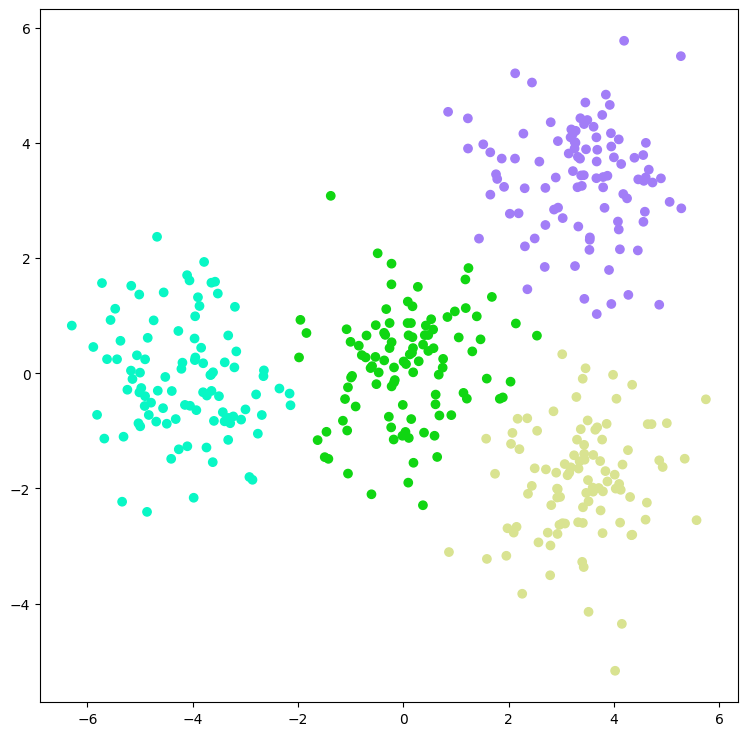

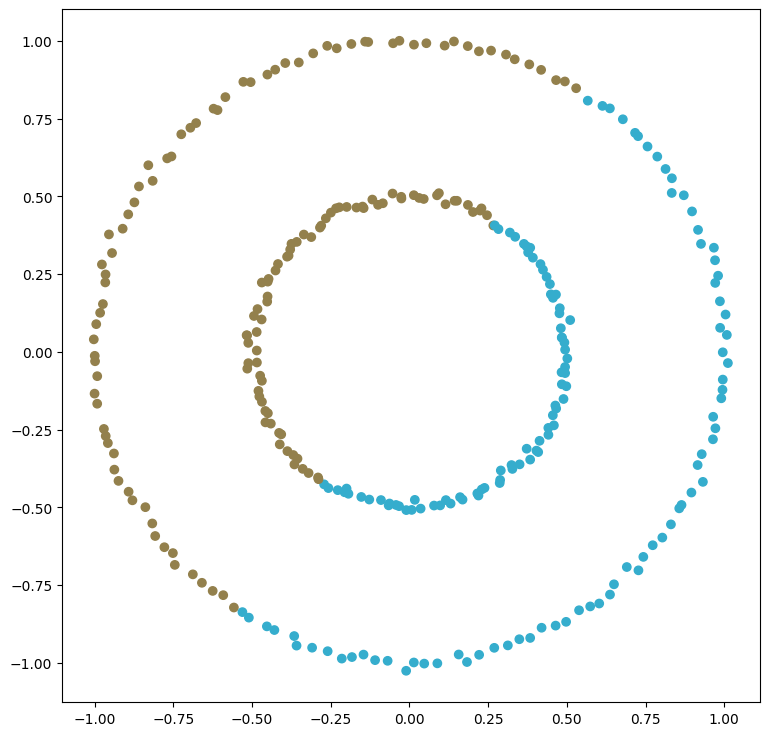

In [23]:
kmeans = KMeans_pp(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans_pp(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### **Task 3. Elbow [15 pts]**

For this task we will switch from synthetic data and work with [iris](https://en.wikipedia.org/wiki/Iris_flower_data_set) dataset. The goal of this task is to idetify how many types of irises there. For this, use an [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). Use any variation of the k-means method (even from sklearn). You can use any clusterization metric but we advise to use sum of the squared distances from points to their centroids (model.interia for the sklearn method). **You need to tell how many classses (or clusters) are in iris dataset**

In [24]:
from sklearn.cluster import KMeans as sklearn_KMeans
from sklearn.datasets import load_iris

[[1, -681.3706], [2, -152.34795176035792], [3, -78.85144142614601], [4, -57.22847321428571], [5, -46.44618205128205], [6, -39.03998724608724], [7, -34.46699028945882], [8, -30.112388528138524], [9, -27.89401218956482]]


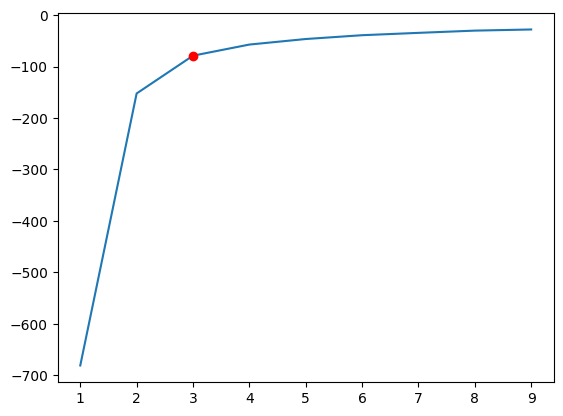

In [25]:
# X_iris
X_iris = load_iris()['data']
result = []
for clusters in range(1, 10):
    clusterization = sklearn_KMeans(n_clusters=clusters).fit(X_iris)
    result.append([clusters, clusterization.score(X_iris)])
print(result)
result = np.array(result)
plt.figure()
plt.plot(result[:, 0], result[:, 1])
plt.plot(result[2][0], result[2][1], 'ro')
plt.show()


As we can see from elbow method the best number of clusters is 3

### **Task 4. Agglomerative clustering [20 pts]**

Implement AgglomerativeClustering.

AgglomerativeClustering is a bottom-up clustering approach. It is initialized with each point in its own cluster. After that iteratively two closest clusters are merged. The procedure ends when the specified numbers of clusters are met.

#### initialization
* n_clusters - number of clusters.


#### methods
`fit_predict(X, y=None)` - trains model on `X` and returns predicted classes for the `X` (y is ignored). Calculate distance between classes as an minimal pairwise distance between points from both clusters (*$min_{p\in C_1, q \in C_2 |p_1-p_2|}$*)



In [26]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        self.k = n_clusters
        if  linkage == "average":
            self.dist_function = self.dist_average
        elif linkage == "complete":
            self.dist_function = self.dist_complete
        else:
            self.dist_function = self.dist_single

    @staticmethod
    def dist_average(ind1, ind2, X):
        return np.mean(np.apply_along_axis(lambda v: np.linalg.norm(v - X[ind1], axis=1), 1, X[ind2]))

    @staticmethod
    def dist_single(ind1, ind2, X):
        return np.min(np.apply_along_axis(lambda v: np.linalg.norm(v - X[ind1], axis=1), 1, X[ind2]))

    @staticmethod
    def dist_complete(ind1, ind2, X):
        return np.max(np.apply_along_axis(lambda v: np.linalg.norm(v - X[ind1], axis=1), 1, X[ind2]))

    def fit_predict(self, X, y=None):
        clusters = {i: [i] for i in range(X.shape[0])}
        dist_matrix = {}
        for i in clusters:
            for j in clusters:
                if i < j:
                    dist_matrix[i, j] = self.dist_function(clusters[i], clusters[j], X)
        while len(clusters) > self.k:
            cl1, cl2 = min(dist_matrix, key=dist_matrix.get)
            clusters[cl1].extend(clusters[cl2])
            del clusters[cl2]
            for cl3 in clusters:
                del dist_matrix[min(cl3, cl2), max(cl3, cl2)]
                if cl3 != cl1:
                    dist_matrix[min(cl3, cl1), max(cl3, cl1)] = self.dist_function(clusters[cl1], clusters[cl3], X)
        ans = -np.ones(X.shape[0]).astype(int)
        for ind, cl in enumerate(clusters):
            ans[clusters[cl]] = ind
        return ans

Test on sythnetoc data. If necessery find best number of clusters

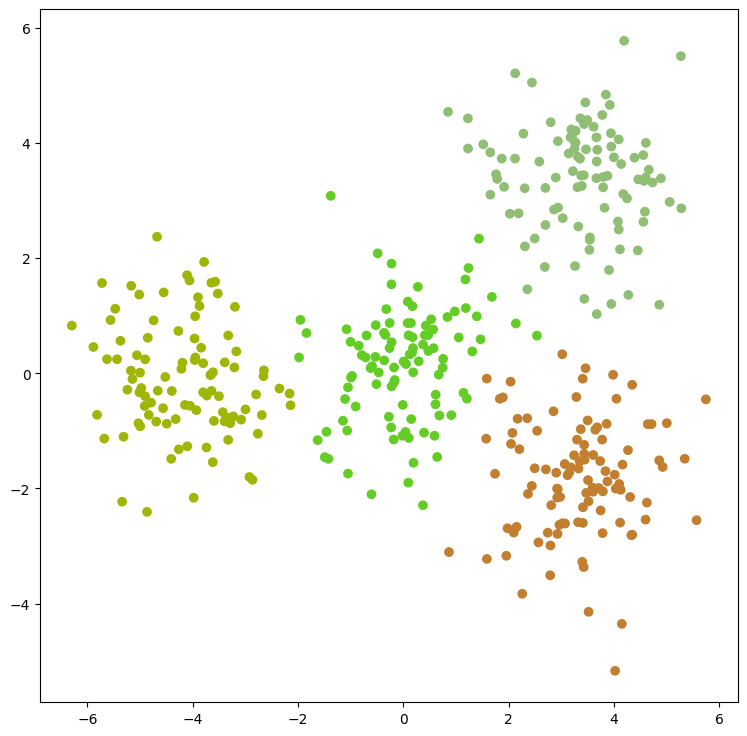

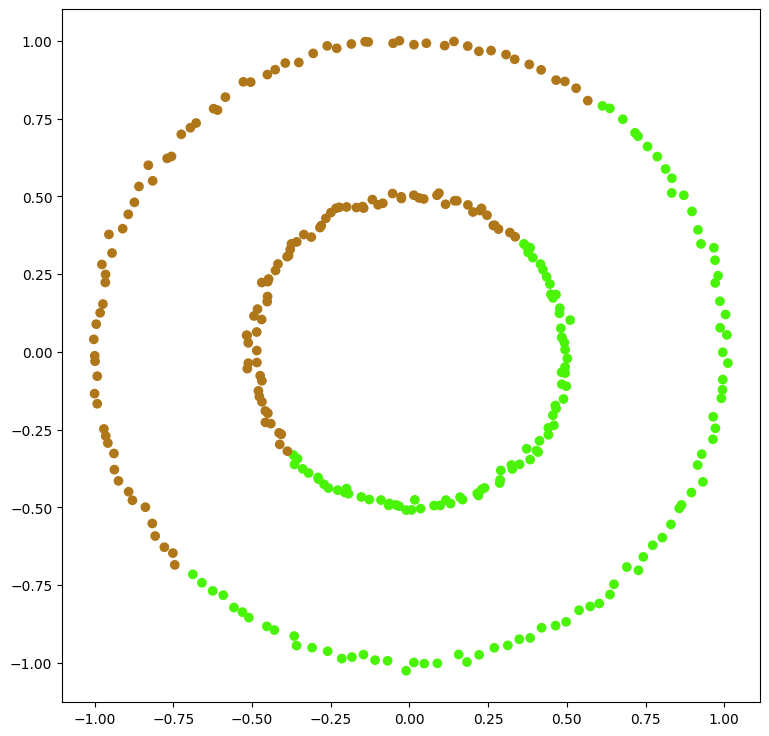

In [27]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### **Task 5. Feature engineering [15 pts]**

Which model k-Means or Agglomerative Clustering is better on the circles data? Why? Is it possible to improve weaker model with the feature engineering? (If yes - show that.)


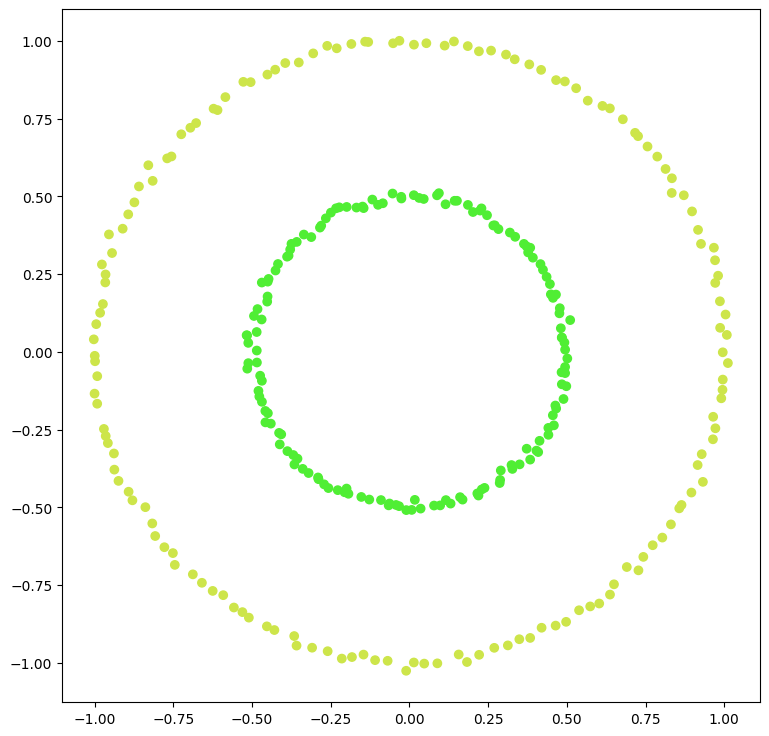

In [28]:
# Both algorithms on standard features are bad on circles data.
# K means is bad because even if it gets the perfect clusterization the next step will break it all. That's because the centroids will be right in the center and all points at the next iteration will be in two parts.
# Agglomerative clustering with mean or max linkage won't do any better because there are situations that can make this algo work wrong. For example if only one half of one circle became one cluster and only one half from the other circle became another cluster then mean between these two clusters will be almost 0.

# However feature linkage can do the trick because it'll go just like Cruscall's algorithm:

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage="simple")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### **Task 6. Pixel clustering [15 pts]**

Implemet function that will clusterize colors of the image with k-Means. The function should return an image where each pixel is replace by the color its centroid. 


*The image is a matrix with [h, w, 3], where h, w is dimentions of the image. A pixel is a vector with 3 values.*



In [29]:
# functions for reading, showing, and saving images
def read_image(path):
    im = cv2.imread(path)
    return im[:, :, ::-1]


def show_image(image):
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def save_image(image, path):
    cv2.imwrite(path, image[:, :, ::-1])

In [30]:
def clusterize_image(image, col=8):
    # you can change signature of the function as you want
    pixels = image.reshape(-1, 3)

    kmeans = sklearn_KMeans(n_clusters=col)
    labels = kmeans.fit_predict(pixels)
    centroids  = kmeans.cluster_centers_
    recolored = np.array([centroids[centroid_index] / 255.0 for centroid_index in labels]).reshape((image.shape[0], image.shape[1], 3))

    return recolored

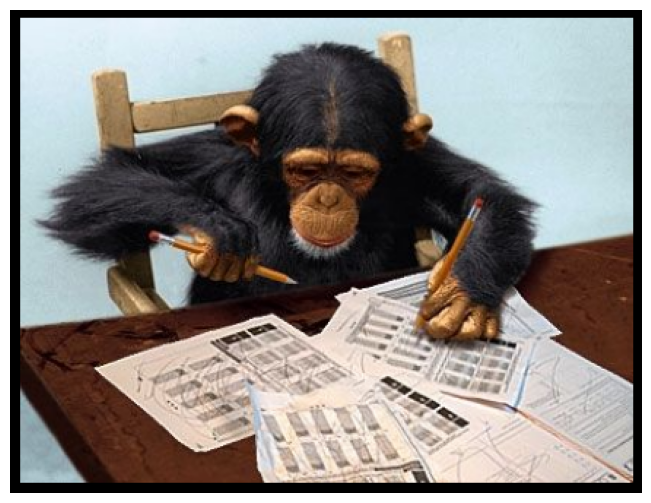

In [31]:
image = read_image("./images/img.png")
show_image(image)

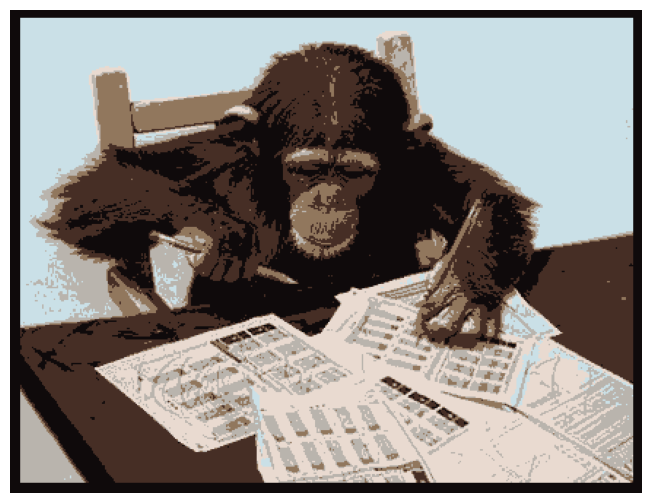

In [32]:
image = read_image("./images/img.png")
result = clusterize_image(image, col=6)
show_image(result)